In [1]:
import string
import random
from timeit import default_timer as timer
from time import sleep, process_time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import scipy

# Gaussian Mixture Model Timing Attack

In this notebook, we attempt to reveal a password based on the time it takes to compare the given password to the correct password.

## Unknown Password

Assume our password can be made up of a restricted set of characters.

In [2]:
alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits
print(f"Alphabet: {alphabet}")

Alphabet: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789


Using these characters, we create a random password which we will treat as unknown throughout the notebook.

In [3]:
unknown_password = ''.join(random.choices(alphabet, k=24))
print(f"Unknown password: {unknown_password}")

Unknown password: 2s4nhLvEeUlaDKuSU3dqFUUC


## Query Information (Slow)

Consider a use case where a server verifies if the password we provide is correct. It will compare the provided password to the correct password stored on the server. For simplicity, let the comparison work by scanning the characters and returning when the first character is different.

In [4]:
def password_compare(unknown_password, guess_password):
    
    i = 0
    
    while i < len(unknown_password) and i < len(guess_password):
       
        if unknown_password[i] != guess_password[i]:
            return
                
        i += 1

Now, the server will tell us if we are right or wrong, but that is not the information we are interested in. We want to know how long it took the server to make this determination. We create a query function that accomplishes this.

In [5]:
def password_query(guess_password):
    
    start = process_time()
    password_compare(unknown_password, guess_password)
    end = process_time()

    return (end - start)

## Exploration (Slow)

Intuitively, we should expect a correct password to take longer to compare than an incorrect password as the correct password has a longer correct prefix than the incorrect password. 

We can test this intuition. Assume we have correctly determined the first 12 characters of the password. We can time how long it takes to compare. We can compare this to the time for a 13 character prefix as well (which should be slightly longer).

In [6]:
t_km1s = []
t_ks = []
deltas = []

for _ in range(100000):
    
    # Note: '!' is NOT in the alphabet! This is important!
    guess_password_km1 = unknown_password[:12] + ('!' * 12)
    t_km1s += [password_query(guess_password_km1) * 1e7]

    guess_password_k = unknown_password[:13] + ('!' * 11)        
    t_ks += [password_query(guess_password_k) * 1e7]

    deltas += [(t_ks[-1] - t_km1s[-1])]

There are going to be a lot of outliers in the timing data due to system interrupts, etc. First we need to restrict the range.

In [57]:
t_km1_range = np.median(t_km1s) - 1.5 * (np.quantile(t_km1s, 0.95) - np.quantile(t_km1s, 0.05)), \
              np.median(t_km1s) + 1.5 * (np.quantile(t_km1s, 0.95) - np.quantile(t_km1s, 0.05))
t_k_range = np.median(t_ks) - 1.5 * (np.quantile(t_ks, 0.95) - np.quantile(t_ks, 0.05)), \
            np.median(t_ks) + 1.5 * (np.quantile(t_ks, 0.95) - np.quantile(t_ks, 0.05))
delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05))

t_range = min(t_km1_range[0], t_k_range[0], delta_range[0]), \
          max(t_km1_range[1], t_k_range[1], delta_range[1])

print(f"Range: {t_range}")

Range: (-29.824999999261692, 151.64499998898685)


Now we can plot and compare the timings.

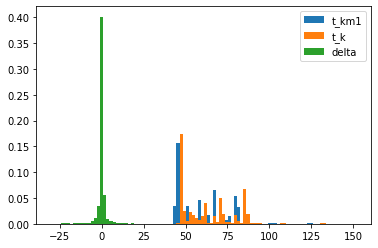

In [65]:
_ = plt.hist(t_km1s, range=t_range, bins=100, density=True, label='t_km1')
_ = plt.hist(t_ks, range=t_range, bins=100, density=True, label='t_k')
_ = plt.hist(deltas, range=t_range, bins=100, density=True, label='delta')
_ = plt.legend()

It looks like we are validated in our reasoning! The 13-character prefix takes longer to validate than the 12-character prefix. The differences are approximately Gaussian centered above zero.

This assumed that we knew the 13th character. But we are trying to guess the next character! Let's see what happens when we scan through the characters.

In [59]:
n_queries = 500
deltas = []

for character in alphabet:
    
    for _ in range(n_queries):

        # Note: '!' is NOT in the alphabet! This is important!
        guess_password_km1 = unknown_password[:12] + ('!' * 12)
        t_km1 = password_query(guess_password_km1) * 1e7

        guess_password_k = unknown_password[:12] + character + ('!' * 11)        
        t_k = password_query(guess_password_k) * 1e7

        deltas += [(t_k - t_km1)]

Once again, there are a lot of outliers. Let's restrict our focus.

In [60]:
delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05))
print(f"Range: {delta_range}")

Range: (-14.777999997050951, 14.777999997050951)


We can plot a histogram of the difference in times.

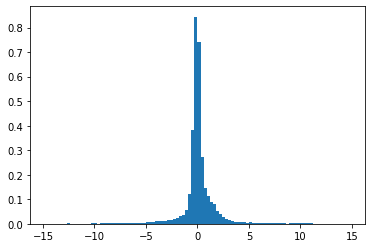

In [66]:
_ = plt.hist(deltas, range=delta_range, density=True, bins=100)

It is kind of difficult to tell, but there should be a little bump to the right for the correct character. Let's cheat for a second and assume we know the next character so we can see this a little better.

In [62]:
next_char_index = alphabet.find(unknown_password[12])
print(f"Next character index: {next_char_index}")

Next character index: 3


Now we can break up our timing deltas into correct and incorrect categories.

In [63]:
incorrect_deltas = deltas[:3 * n_queries] + deltas[(3 + 1) * n_queries:]
correct_deltas = deltas[3 * n_queries:(3 + 1) * n_queries]

Now we should be able to highlight the correct characters' deltas in the histogram. Note the histograms are normalized such that their area is equal to one.

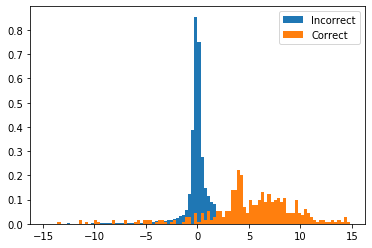

In [68]:
_ = plt.hist(incorrect_deltas, range=delta_range, density=True, bins=100, label='Incorrect')
_ = plt.hist(correct_deltas, range=delta_range, density=True, bins=100, label='Correct')
_ = plt.legend()

## Naive Approach (Slow)

It appears like the difference in averages of the two distributions from before is large enough to observe. To be resistant to outliers, let's use the median of the different deltas for each character.

In [69]:
medians = []

for i in range(len(alphabet)):
    
    medians += [np.median(deltas[i * n_queries : (i + 1) * n_queries])]

We can plot the medians across all the characters.

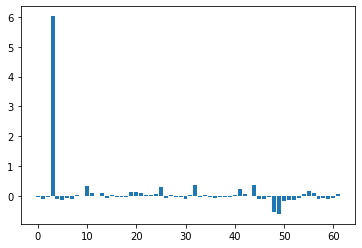

In [70]:
_ = plt.bar(range(len(alphabet)), medians)

We can take the character with the maximum of the medians to guess the next unknown character in the password.

In [73]:
print(f"Next character guess: {np.argmax(medians)}")

Next character guess: 3


This corresponds to the correct next character in the password!

## Gaussian Mixture Model Approach (Slow)

Now we can be a little more technical in our approach. First we clean our data to remove the outliers as above.

In [74]:
deltas_clean = list(filter(lambda delta: (delta > delta_range[0]) and (delta < delta_range[1]), deltas))

Now we fit a 2-component Gaussian mixture to our data.

In [86]:
gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(deltas_clean).reshape(-1, 1))

We can take a look at the learned parameters to confirm everything makes sense.

In [84]:
print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: -0.01277003045462859, 0.3793750195419583
Variances: 0.14448377868525622, 13.845941993397654
Weights: 0.7183095799244188, 0.2816904200755729


We also plot the Gaussian PDFs to visualize the fit.

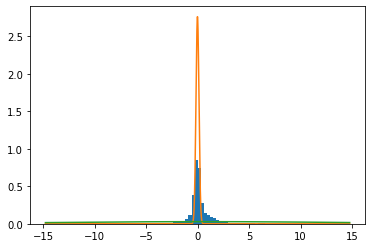

In [85]:
_ = plt.hist(deltas, range=delta_range, bins=100, density=True)

xx = np.arange(delta_range[0], delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

It looks like the fit is decent! However, it is hard to tell if the second Gaussian fits well because it has such a large variance. This is why we look at the numerical values above.

We determine which Gaussian has lower weight. The Gaussian with lower weight will be the correct character distribution because it is always seen more infrequently.

In [88]:
correct_distribution = np.argmin(gmm.weights_)
print(f"Correct distribution: {correct_distribution}")

Correct distribution: 0


We can now calculate the number of times we predict a character belongs to this distribution.

In [99]:
probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1))) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1))) / n_queries]


Now we can visualize the probabilities for each character being from the correct distribution.

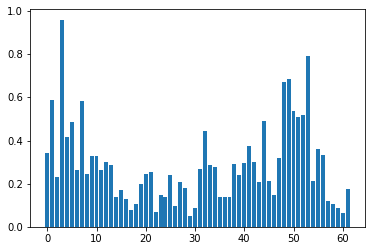

In [100]:
_ = plt.bar(range(0, len(alphabet)), probs)

We can take the character with the maximum of the probabilities to guess the next unknown character in the password.

In [102]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 3


This also corresponds to the correct next character in the password! But why should we go through this more sophisticated approach?